# 데이터 준비

In [1]:
!wget http://ai.stanford.edu/~jkrause/car196/bmw10_release.tgz

--2022-07-05 06:56:35--  http://ai.stanford.edu/~jkrause/car196/bmw10_release.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59628953 (57M) [application/x-gzip]
Saving to: ‘bmw10_release.tgz’

bmw10_release.tgz   100%[===================>]  56.87M  15.9MB/s    in 5.5s    

2022-07-05 06:56:41 (10.3 MB/s) - ‘bmw10_release.tgz’ saved [59628953/59628953]



In [2]:
!tar xvfz bmw10_release.tgz

bmw10_ims/
bmw10_ims/10/
bmw10_ims/10/150303361.jpg
bmw10_ims/10/150303689.jpg
bmw10_ims/10/150304122.jpg
bmw10_ims/10/150304536.jpg
bmw10_ims/10/150302397.jpg
bmw10_ims/10/150304216.jpg
bmw10_ims/10/150304396.jpg
bmw10_ims/10/150302795.jpg
bmw10_ims/10/150303565.jpg
bmw10_ims/10/150303015.jpg
bmw10_ims/10/150303922.jpg
bmw10_ims/10/150304871.jpg
bmw10_ims/10/150302515.jpg
bmw10_ims/10/150304453.jpg
bmw10_ims/10/150304421.jpg
bmw10_ims/10/150304828.jpg
bmw10_ims/10/150304381.jpg
bmw10_ims/10/150303002.jpg
bmw10_ims/10/150304813.jpg
bmw10_ims/10/150304132.jpg
bmw10_ims/10/150302770.jpg
bmw10_ims/10/150302307.thumb.jpg
bmw10_ims/10/150302884.jpg
bmw10_ims/10/150304480.thumb.jpg
bmw10_ims/10/150304550.jpg
bmw10_ims/10/150302686.jpg
bmw10_ims/10/150304261.jpg
bmw10_ims/10/150303349.jpg
bmw10_ims/10/150304672.jpg
bmw10_ims/10/150303829.jpg
bmw10_ims/10/150304740.jpg
bmw10_ims/10/150304294.jpg
bmw10_ims/10/150304410.jpg
bmw10_ims/10/150303122.jpg
bmw10_ims/10/150303008.jpg
bmw10_ims/10/15030

# 모델 학습

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_1 (Flatten)         (None, 68992)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               17662208  
                                                                 
 encoded (BatchNormalization  (None, 256)              1024      
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 25,434,371
Trainable params: 17,665,290
Non-trainable params: 7,769,081
__________________________________

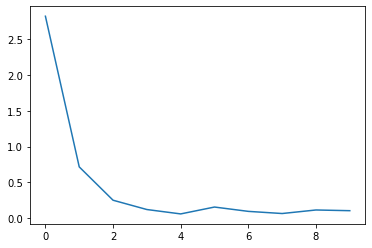

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization(name="encoded"))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "bmw10_ims",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

# test_data_generator = ImageDataGenerator(
#       preprocessing_function=preprocessor
# ).flow_from_directory(
#       "dogs_prepared/test",
#       target_size=(224,224),
#       batch_size=BATCH_SIZE,
#       class_mode='sparse'
# )


history = model.fit(
      train_data_generator,
    #   validation_data=test_data_generator,
      epochs=10
)


plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.show()


# loss, acc = model.evaluate(test_data_generator)
# print("loss=", loss)
# print("acc=", acc)



# batch_x, batch_y = test_data_generator.next()
# y_ = model.predict(batch_x)
# predicted = np.argmax(y_, axis=-1)

# plt.plot(batch_y[:100], "o")
# plt.plot(predicted[:100], '.')
# plt.show()


# custom_labels = list(test_data_generator.class_indices.keys())
# print("label category index =", batch_y[0])
# print("predicted category index =", predicted[0])
# print("predicted category name =", custom_labels[predicted[0]])


# 인코딩

In [5]:
encoder = Model(inputs=model.input, outputs=model.layers[-2].output)

images = []
codes = []
for i in range(len(train_data_generator)):
    batch_x, batch_y = next(train_data_generator)
    encoded = encoder(batch_x)
    images.extend(batch_x)
    codes.extend(encoded)

images = np.array(images)
codes = np.array(codes)

print(images.shape)
print(codes.shape)

(512, 224, 224, 3)
(512, 256)


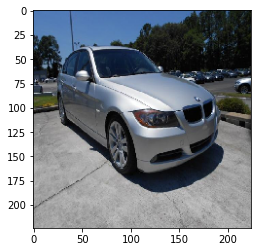

In [48]:
batch_x, batch_y = next(train_data_generator)

target_image = batch_x[0]
target_code = encoder.predict(batch_x)[0]

plt.imshow(target_image.astype(int))
plt.show()

# 가까운 영상 찾기

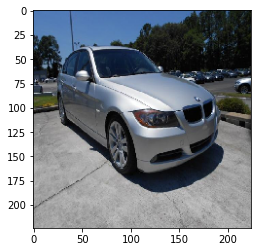

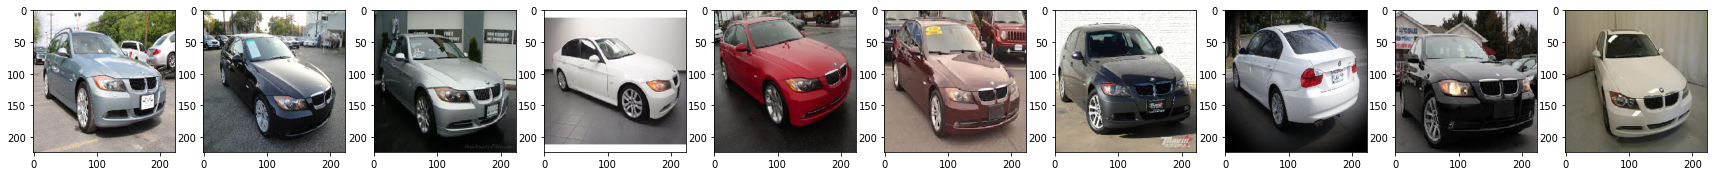

In [49]:
from scipy.spatial import distance

distances = [distance.euclidean(target_code, code) for code in codes]
similar_index = np.argsort(distances)

plt.imshow(target_image.astype(int))
plt.show()
n = 10
plt.figure(figsize=(30,3))
for i in range(1,n+1):
    plt.subplot(1,n,i)
    plt.imshow(images[similar_index[i]].astype(int))
plt.show()
